In [1]:
# import  libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [2]:
# import data
data_train = pd.read_csv("wave10k_train.txt", sep = "\t")
data_test = pd.read_csv("wave10k_test.txt", sep = "\t")

In [3]:
# data dimensions
print(data_train.shape)
print(data_test.shape)

(10000, 22)
(10000, 22)


In [4]:
# portion the classes in the data
print(data_train['ONDE'].value_counts(normalize=True))

ONDE
A    0.3367
C    0.3335
B    0.3298
Name: proportion, dtype: float64


In [5]:
# Porportion des classes dans le test
print(data_test['ONDE'].value_counts(normalize=True))

ONDE
C    0.3388
B    0.3324
A    0.3288
Name: proportion, dtype: float64


In [6]:
from sklearn.svm import SVC

X_train = data_train.drop("ONDE", axis=1)
y_train = data_train["ONDE"]

svc = SVC(random_state=0, kernel="linear", probability=True)
svc.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=0)

In [7]:
# fonction pour mesurer la performance
def evaluate_model(model, test_data):
    # prediction
    prediction = model.predict(test_data.iloc[:, :-1])

    # taux d'erreur 
    error_rate = 1.0 - mt.accuracy_score(test_data.iloc[:, -1], prediction)
    return error_rate


In [8]:
# import metrics as mt
import sklearn.metrics as mt
error_rate = evaluate_model(svc, data_test)
print(error_rate)

0.13590000000000002


## **Random Sampling**

In [9]:
# random sampling 100 in data_test
seed = 1
data_test_100 = data_train.sample(100, random_state=seed)

# create new model with 100 samples
svc_100 = SVC(random_state=0, kernel="linear", probability=True)
svc_100.fit(data_test_100.iloc[:, :-1], data_test_100.iloc[:, -1])


SVC(kernel='linear', probability=True, random_state=0)

In [10]:
# evaluate the model
error_rate_100 = evaluate_model(svc_100, data_test)
print(error_rate_100)

0.20530000000000004


In [11]:
# To avoid the FutureWarning, specify the dtypes when creating an empty DataFrame:
train_data_used = pd.DataFrame(columns=data_train.columns).astype(data_train.dtypes)
remaining_data = data_train.copy()

error_rates_iter = []
for i in range(19):
    new_samples = remaining_data.sample(100, random_state=1)
    remaining_data.drop(new_samples.index, inplace=True)
    train_data_used = pd.concat([train_data_used, new_samples], ignore_index=True)

    X_iter = train_data_used.drop("ONDE", axis=1)
    y_iter = train_data_used["ONDE"]

    model_iter = SVC(kernel="linear", probability=True, random_state=0)
    model_iter.fit(X_iter, y_iter)

    error_rate_iter = evaluate_model(model_iter, data_test)
    error_rates_iter.append(error_rate_iter)

print(error_rates_iter)

[0.20530000000000004, 0.19569999999999999, 0.1977, 0.18159999999999998, 0.16769999999999996, 0.1613, 0.16369999999999996, 0.16169999999999995, 0.15500000000000003, 0.1532, 0.14790000000000003, 0.14849999999999997, 0.1532, 0.14780000000000004, 0.14959999999999996, 0.1472, 0.1462, 0.14759999999999995, 0.14649999999999996]


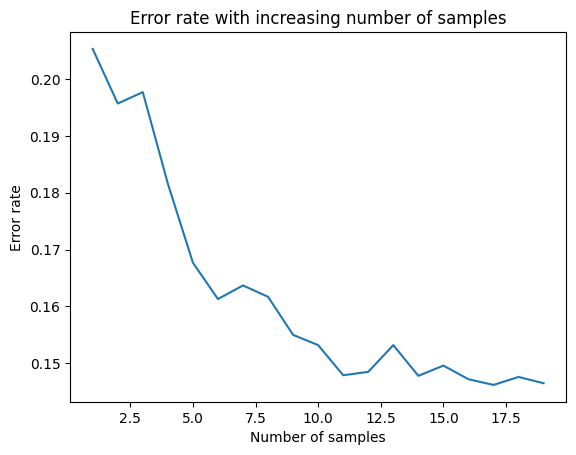

In [12]:
# plot the error rates
plt.plot(range(1, 20), error_rates_iter)
plt.xlabel("Number of samples")
plt.ylabel("Error rate")
plt.title("Error rate with increasing number of samples")
plt.show()

## **Active Learning**

In [13]:
# Réinitialiser le générateur de nombre aléatoire avec la même graine
seed = 1
train_data_used = data_train.sample(100, random_state=seed)
remaining_data = data_train.drop(train_data_used.index)

error_rates_active = []

for i in range(19):
    # Appliquer le modèle de l'étape précédente sur la base résiduelle
    X_remaining = remaining_data.drop("ONDE", axis=1)
    y_remaining = remaining_data["ONDE"]
    
    model_active = SVC(kernel="linear", probability=True, random_state=seed)
    model_active.fit(train_data_used.drop("ONDE", axis=1), train_data_used["ONDE"])
    
    # Calculer les probabilités d'appartenance aux classes
    probabilities = model_active.predict_proba(X_remaining)
    
    # Identifier les 100 individus pour lesquels l'appartenance aux classes est la moins tranchée
    max_probabilities = probabilities.max(axis=1)
    uncertain_indices = max_probabilities.argsort()[:100]
    
    # Rajouter ces 100 individus à la base d'entraînement
    new_samples = remaining_data.iloc[uncertain_indices]
    train_data_used = pd.concat([train_data_used, new_samples], ignore_index=True)
    
    # Retirer ces 100 individus de la base résiduelle
    remaining_data = remaining_data.drop(new_samples.index)
    
    # Modéliser sur la nouvelle base d'entraînement
    model_active.fit(train_data_used.drop("ONDE", axis=1), train_data_used["ONDE"])
    
    # Évaluer sur TEST
    error_rate_active = evaluate_model(model_active, data_test)
    error_rates_active.append(error_rate_active)

print(error_rates_active)

[0.17969999999999997, 0.16059999999999997, 0.15049999999999997, 0.1523, 0.14959999999999996, 0.14559999999999995, 0.1462, 0.14480000000000004, 0.14500000000000002, 0.14590000000000003, 0.14380000000000004, 0.14490000000000003, 0.14300000000000002, 0.14259999999999995, 0.14259999999999995, 0.14270000000000005, 0.14249999999999996, 0.14190000000000003, 0.14129999999999998]


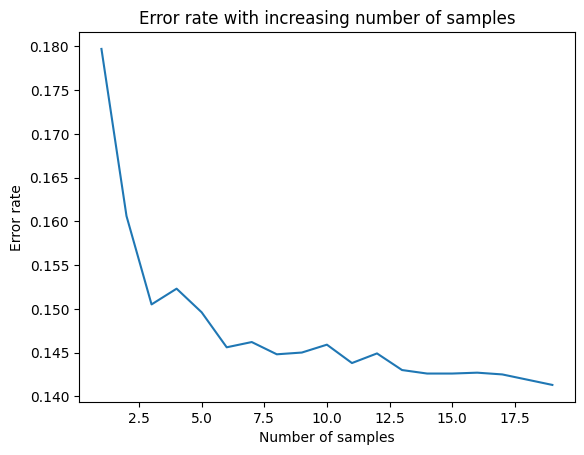

In [14]:
# plot the error rates
plt.plot(range(1, 20), error_rates_active)
plt.xlabel("Number of samples")
plt.ylabel("Error rate")
plt.title("Error rate with increasing number of samples")
plt.show()

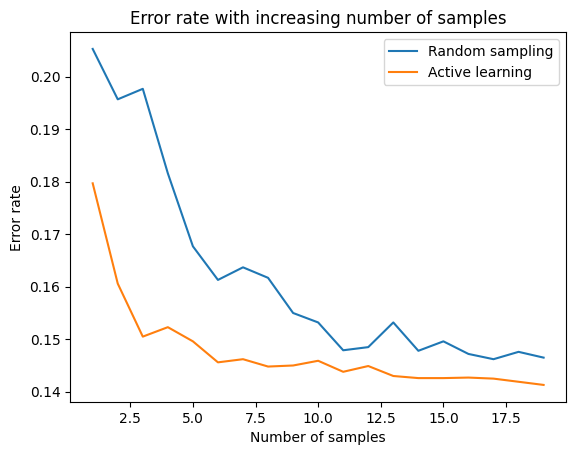

In [15]:
# afficher les deux courbes sur le même graphique
plt.plot(range(1, 20), error_rates_iter, label="Random sampling")
plt.plot(range(1, 20), error_rates_active, label="Active learning")
plt.xlabel("Number of samples")
plt.ylabel("Error rate")
plt.title("Error rate with increasing number of samples")
plt.legend()
plt.show()
